In [1]:
from photerr import LsstErrorModel
import pandas as pd
import numpy as np
import lbg_forecast.noise as noise
import lbg_forecast.emulator as em
import lbg_forecast.nz as nz
import lbg_forecast.colour_cuts as cuts
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.emulator as em
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import matplotlib.pyplot as plt
import scipy as sc
import lbg_forecast.selection as sel
import lbg_forecast.noise as noise
import lbg_forecast.colour_cuts as cuts

In [3]:
# initalise fsps emulator
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [4]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

In [5]:
bounds = hyp.hyperparameter_tighter()
nhypersamples = 1
hyperparameter_samples = np.vsplit(hyp.sample_prior_parameters(nhypersamples, bounds[0], bounds[1]), nhypersamples)
prior_data = pr.preload_prior_data(zmax=7.0)

In [6]:
nsamples = 200000
nzs = []
spsp = []
for row in hyperparameter_samples:
    sps_params = pop.generate_sps_parameters(nsamples, row[0], prior_data, uniform_redshift_mass=False, uniform_logf=False)
    noiseless_photometry = model.mimic_photometry(sps_params, 1000)

    #lbg_nzs = nz.simulate_nzs(sps_params, model, 1000)
    #nzs.append(lbg_nzs)
    #spsp.append(sps_params)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


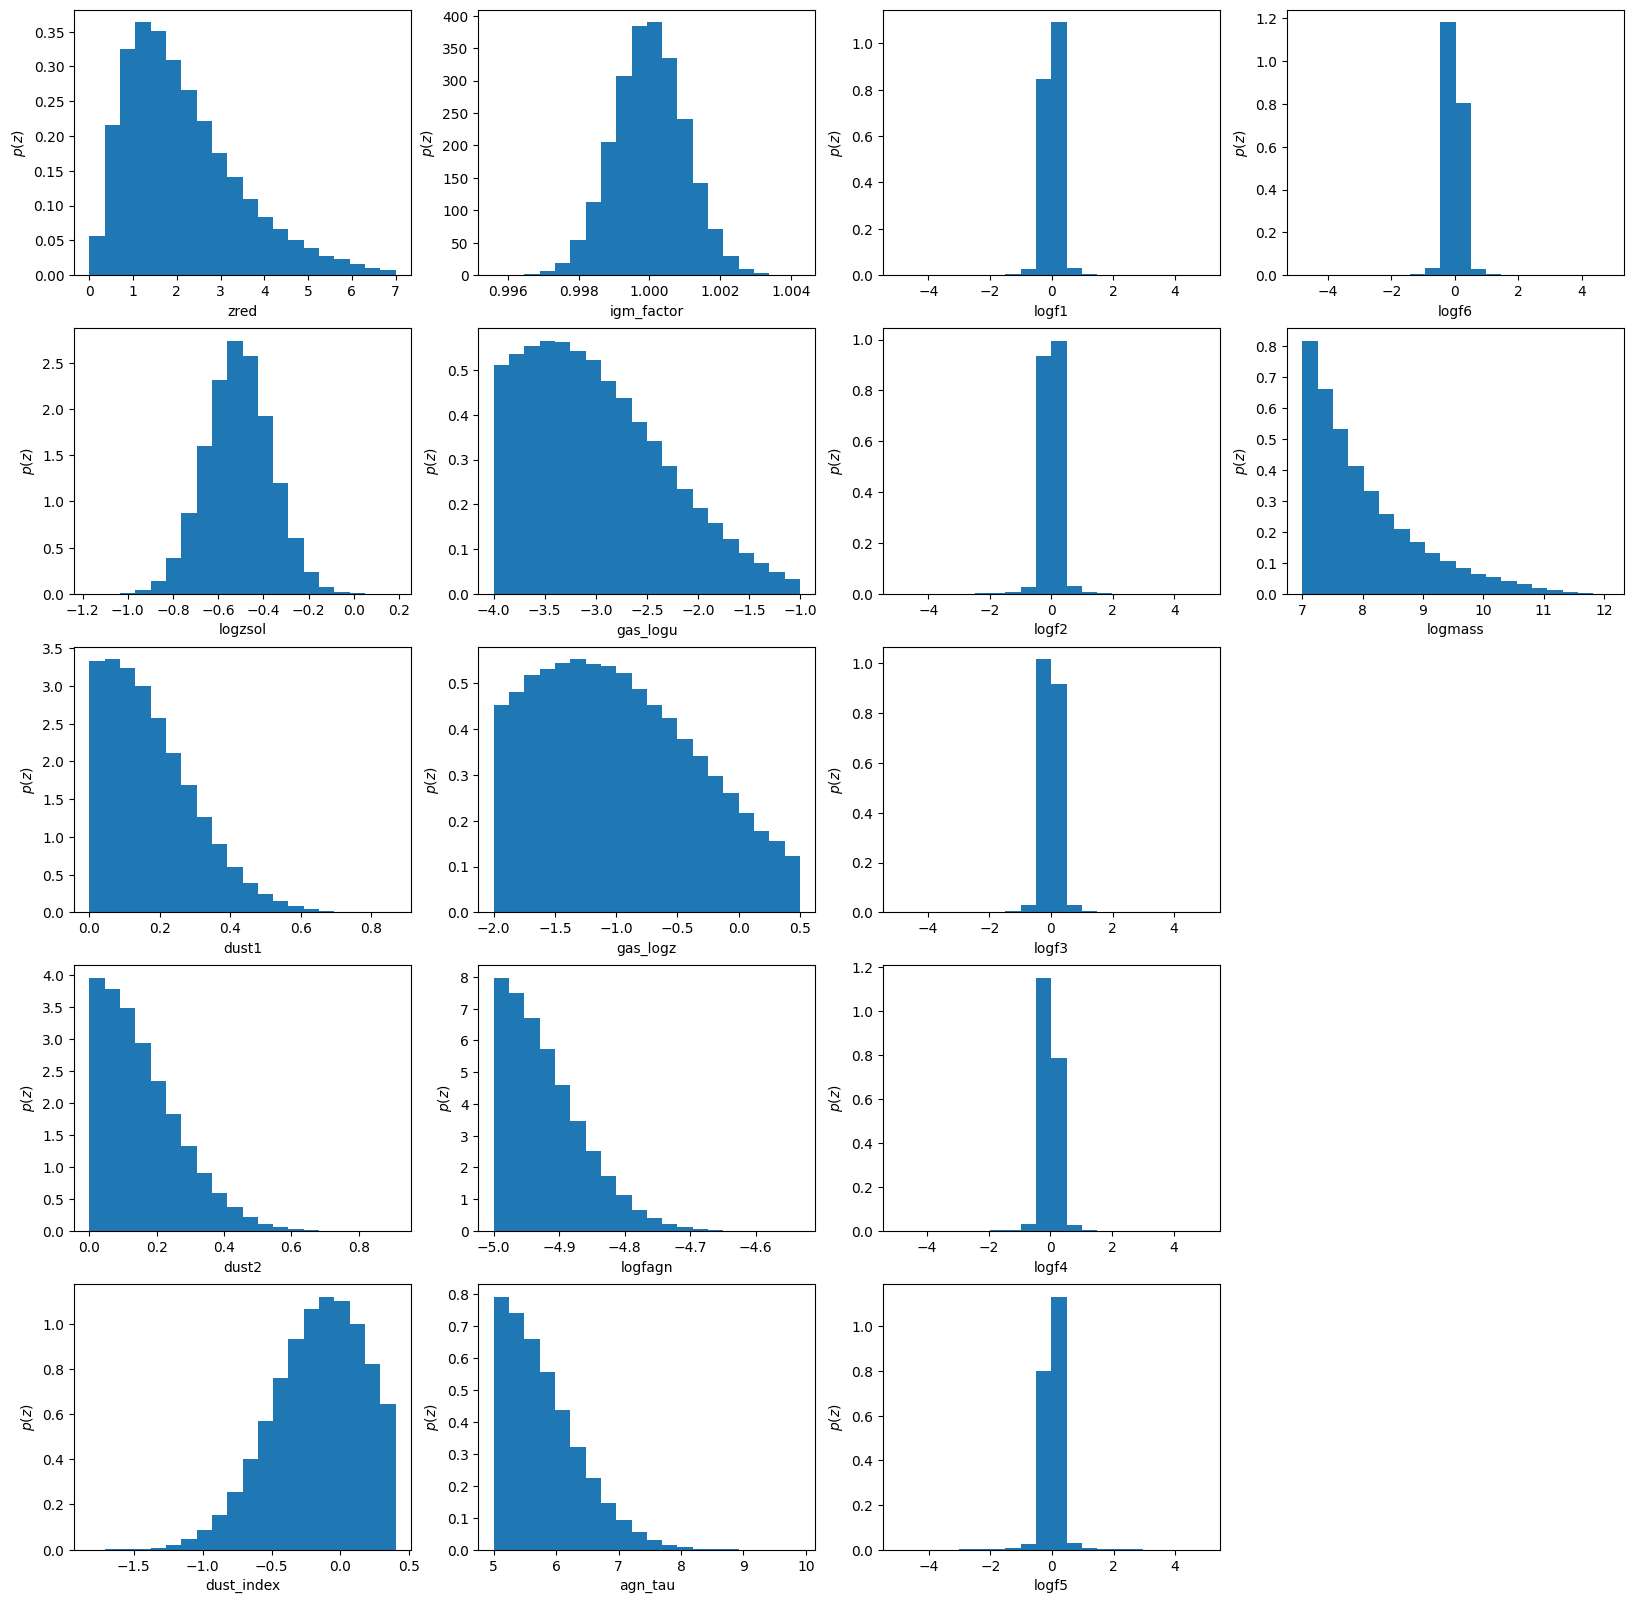

In [7]:
pop.plot_galaxy_population(sps_params)

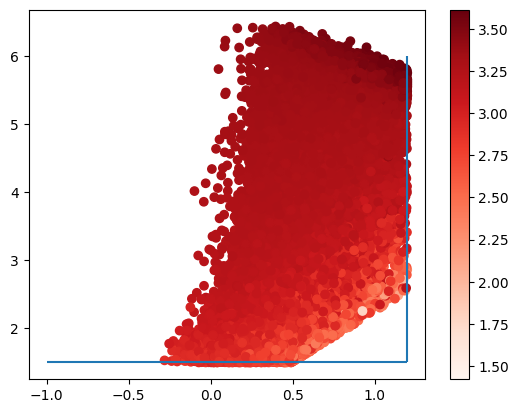

In [8]:
colours = sel.calculate_colours(noiseless_photometry)
umg = colours[:, 0]
gmr = colours[:, 1]
redshifts = sps_params[:, 0]
umg_lbgs = umg[cuts.sources_inside_u_cuts(umg, gmr)]
gmr_lbgs = gmr[cuts.sources_inside_u_cuts(umg, gmr)]
redshifts_lbgs = redshifts[cuts.sources_inside_u_cuts(umg, gmr)]
plt.hlines(1.5, -1.0, 1.2)
plt.vlines(1.2, 1.5, 6.0)
plt.scatter(gmr_lbgs, umg_lbgs, c=redshifts_lbgs, cmap='Reds')
plt.colorbar()

Text(0.5, 0, 'z')

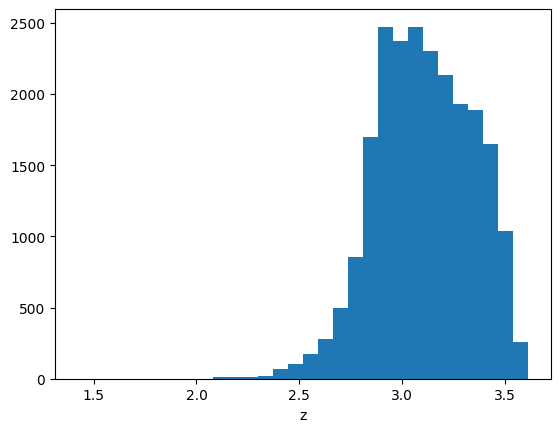

In [9]:
plt.hist(redshifts_lbgs[0], bins=30)
plt.xlabel('z')

In [10]:
#noiseless_photometry = np.load("/Users/fpetri/repos/LBGforecast/data/data/training_data.npy")[:200000, :5]
#sps_params = np.load("/Users/fpetri/repos/LBGforecast/data/data/training_params.npy")[:200000, :]
catalog = pd.DataFrame(noiseless_photometry, columns=['u', 'g', 'r', 'i', 'z'])

In [11]:
catalog

,u,g,r,i,z
0,29.949993,29.713598,29.049311,28.266370,27.838960
1,26.136433,25.894779,25.825579,25.816197,25.727680
2,32.644118,32.383317,32.045636,31.940634,31.754601
3,31.806593,30.526457,30.227578,30.219385,30.200898
4,28.216322,28.205751,28.088294,27.929183,27.844614
...,...,...,...,...,...
199995,33.685923,32.689497,32.283880,32.178872,31.962976
199996,31.866775,31.002864,30.693557,30.651300,30.534536
199997,40.405413,36.071570,33.787187,33.385941,33.236174
199998,28.188558,27.983018,27.425698,26.905582,26.437921


In [12]:
random_state=42
errModel = LsstErrorModel(sigLim=0, absFlux=True)
sig5detections = LsstErrorModel(sigLim=5)
#sig2detections = LsstErrorModel(sigLim=2)

observed_catalog = errModel(catalog, random_state=random_state).filter(['u', 'g', 'r', 'i', 'z']).replace([np.inf, -np.inf], np.nan, inplace=False)
#observed_catalog = observed_catalog.dropna(axis=0)
catalog_sig5 = sig5detections(observed_catalog, random_state=random_state).filter(['u', 'g', 'r', 'i', 'z']).replace([np.inf, -np.inf], np.nan, inplace=False)
catalog_sig5.rename(columns={"u": "u5", "g": "g5", "r": "r5", "i": "i5", "z": "z5"}, inplace=True)

#catalog_sig2 = sig2detections(observed_catalog, random_state=random_state).filter(['u', 'g', 'r', 'i', 'z']).replace([np.inf, -np.inf], np.nan, inplace=False)
#catalog_sig2.rename(columns={"u": "u2", "g": "g2", "r": "r2", "i": "i2", "z": "z2"}, inplace=True)

observed_catalog = observed_catalog.join(catalog_sig5)#.join(catalog_sig2)

In [13]:
sig5detections

Photometric error model with parameters:

LsstErrorParamsV2(nYrObs=10.0, nVisYr={'u': 6.3, 'g': 6.8, 'r': 18.1, 'i': 18.8, 'z': 16.6, 'y': 16.3}, gamma={'u': 0.038, 'g': 0.039, 'r': 0.039, 'i': 0.039, 'z': 0.039, 'y': 0.039}, m5={}, tvis={'u': 38, 'g': 30, 'r': 30, 'i': 30, 'z': 30, 'y': 30}, airmass={'u': 1.15, 'g': 1.15, 'r': 1.14, 'i': 1.15, 'z': 1.16, 'y': 1.16}, Cm={'u': 22.968, 'g': 24.582, 'r': 24.602, 'i': 24.541, 'z': 24.371, 'y': 23.84}, dCmInf={'u': 0.543, 'g': 0.088, 'r': 0.043, 'i': 0.028, 'z': 0.019, 'y': 0.016}, msky={'u': 22.65, 'g': 22.07, 'r': 21.1, 'i': 19.99, 'z': 19.04, 'y': 18.28}, mskyDark={'u': 23.052, 'g': 22.254, 'r': 21.198, 'i': 20.463, 'z': 19.606, 'y': 18.602}, theta={'u': 1.22, 'g': 1.09, 'r': 1.02, 'i': 0.99, 'z': 1.01, 'y': 0.99}, km={'u': 0.47, 'g': 0.213, 'r': 0.126, 'i': 0.096, 'z': 0.068, 'y': 0.171}, tvisRef=30, sigmaSys=0.005, sigLim=5, ndMode='flag', ndFlag=inf, absFlux=False, extendedType='point', aMin=0.7, aMax=2.0, majorCol='major', minorCol='

In [14]:
udrop = observed_catalog.copy(deep=True)

udrop = udrop.dropna(axis=0, subset=['g5'])
udrop = udrop.dropna(axis=0, subset=['r5'])
#udrop = udrop.dropna(axis=0, subset=['u']) 

udrop = udrop.drop(udrop[np.isnan(udrop.u5) == False].index)
#udrop['u'].replace(np.nan, 30.0, inplace=True)

udrop = udrop.drop(udrop[udrop.r < 23].index)
#udrop = udrop.drop(udrop[udrop.r > 25].index)

udrop = udrop.filter(['u', 'g5', 'r5'])

In [15]:
udrop

,u,g5,r5
1,26.667879,25.873302,25.870594
13,26.429631,26.525761,26.637695
27,26.299480,25.668125,25.147723
40,26.613613,26.360572,26.529725
46,27.210770,26.243098,25.542765
...,...,...,...
199787,28.716189,26.593553,26.863192
199802,26.704626,26.569007,26.538906
199833,26.069323,24.853507,24.123378
199835,32.098945,26.597194,26.373336


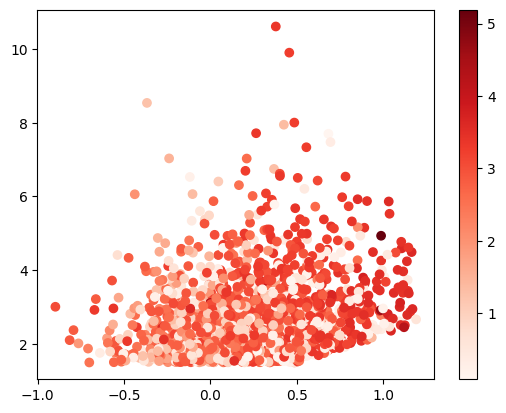

In [16]:
u = udrop['u'].to_numpy()
g = udrop['g5'].to_numpy()
r = udrop['r5'].to_numpy()

u_indexes = udrop['u'].index.to_numpy()
g_indexes = udrop['g5'].index.to_numpy()
r_indexes = udrop['r5'].index.to_numpy()

umg = u-g
gmr = g-r

indexes = cuts.sources_inside_u_cuts(umg, gmr)[0]

plt.scatter(gmr[indexes], umg[indexes], c=sps_params[u_indexes, 0][indexes], cmap='Reds')
plt.colorbar()


(array([0.0234192 , 0.26346604, 0.36299766, 0.33372365, 0.25175644,
        0.28103044, 0.18149883, 0.20491803, 0.21662763, 0.18149883,
        0.11124122, 0.09953162, 0.10538642, 0.15807963, 0.15222482,
        0.08196721, 0.09367681, 0.09953162, 0.08782201, 0.06440281,
        0.07025761, 0.07611241, 0.08782201, 0.19906323, 0.31030445,
        0.28103044, 0.33372365, 0.56791569, 0.6440281 , 0.72014052,
        0.73770492, 0.68501171, 0.70257611, 0.59133489, 0.32786885,
        0.21077283, 0.04683841, 0.0175644 , 0.        , 0.0058548 ,
        0.        , 0.        , 0.0058548 , 0.0058548 , 0.        ,
        0.0058548 , 0.0058548 , 0.        , 0.        , 0.        ,
        0.        , 0.0058548 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 

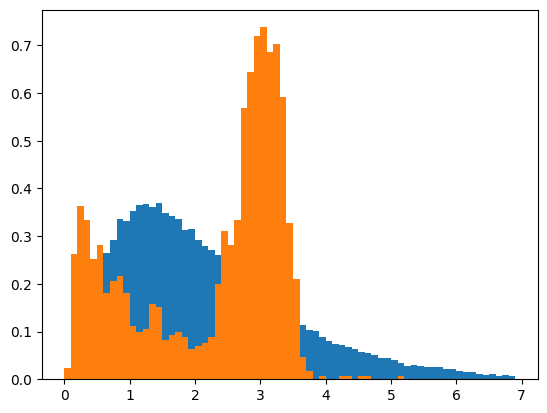

In [17]:
plt.hist(sps_params[:, 0], density=True, bins=bins)
plt.hist(sps_params[u_indexes, 0][indexes], density=True, bins=bins)